ある匂い物質の化学的情報を入力として、おの物質の匂いのスコアを予測する
ここでは予測する匂いを1つに限定し、学習に使用する特徴量を限定することで特徴量の次元を削減し、予測精度の向上を目指す。

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
# フォルダの移動には"%cd"を使用します。
# 作業フォルダへ移動
%cd /content/drive/'My Drive'/'情報管理'/'卒論'
# 現在のフォルダの中身を表示
%ls

Mounted at /content/drive
/content/drive/My Drive/情報管理/卒論
 aaa.ipynb                                random_forest.ipynb
 aaa.xlsx                                 rdkit_desc.csv
'ATLAS_odor_character_profiles (1).csv'   tunerCV.ipynb
 ATLAS_odor_character_profiles.csv        Untitled0.ipynb
 b.xlsx                                   Untitled1.ipynb
 lgbm_tuner_cv.ipynb                      Untitled2.ipynb
 lgbmチューニング.ipynb                   Untitled3.ipynb
 lgmb.ipynb                               Untitled5.ipynb
 light_alldata.ipynb                      xgboost.ipynb
 lightgbm_mo3.ipynb                       全データ個別ipynb
 maccskeys.csv                            全データ自動.ipynb
 mordred_desc.csv                         卒論最新.ipynb
 morganfp2.csv                            各データ特徴量.ipynb
 morganfp3.csv                            学習曲線ipynb.ipynb
 my_dataframe.xlsx


In [ ]:
import os
import sys
import argparse
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt

##データ準備

In [ ]:
#説明変数に用いる
df_maccskeys = pd.read_csv('maccskeys.csv', sep='\t')
df_maccskeys=df_maccskeys.add_prefix('ma_')
df_mordred_desc = pd.read_csv('mordred_desc.csv', sep='\t')
df_mordred_desc=df_mordred_desc.add_prefix('mord_')
df_morganfp2 = pd.read_csv('morganfp2.csv', sep='\t')
df_morganfp2=df_morganfp2.add_prefix('m2_')
df_morganfp3 = pd.read_csv('morganfp3.csv', sep='\t')
df_morganfp3=df_morganfp3.add_prefix('m3_')
df_rdkit = pd.read_csv('rdkit_desc.csv', sep='\t')
df_rdkit=df_rdkit.add_prefix('rd_')

#目的変数に用いる
df_atlas = pd.read_csv('ATLAS_odor_character_profiles.csv', sep='\t')

df_maccskeys = df_maccskeys.rename(columns={'ma_CAS': 'CAS', 'ma_Molecule': 'Molecule'})
df_mordred_desc = df_mordred_desc.rename(columns={'mord_CAS': 'CAS', 'mord_Molecule': 'Molecule'})
df_morganfp2 = df_morganfp2.rename(columns={'m2_CAS': 'CAS', 'm2_Molecule': 'Molecule'})
df_morganfp3 = df_morganfp3.rename(columns={'m3_CAS': 'CAS', 'm3_Molecule': 'Molecule'})
df_rdkit = df_rdkit.rename(columns={'rd_CAS': 'CAS', 'rd_Molecule': 'Molecule'})


In [ ]:
data1 = pd.merge(df_rdkit.dropna(axis=1), 
df_maccskeys.dropna(axis=1), on=['CAS','Molecule'],how='left')

data2 = pd.merge(df_mordred_desc.dropna(axis=1), 
data1.dropna(axis=1), on=['CAS','Molecule'],how='left')

data3 = pd.merge(df_morganfp2.dropna(axis=1), 
data2.dropna(axis=1), on=['CAS','Molecule'],how='left')

data4 = pd.merge(df_morganfp3.dropna(axis=1), 
data3.dropna(axis=1), on=['CAS','Molecule'],how='left')

#目的変数をATLASの匂いの中の"'132_GARLIC_ONION"とする
data5 = pd.merge(df_atlas.loc[:, ['Molecule', 'CAS','132_GARLIC_ONION']], 
data4.dropna(axis=1), on=['CAS','Molecule'],how='right')

drop_col = ['132_GARLIC_ONION','Molecule','CAS']
#説明変数
x_all=data5.drop(drop_col,axis=1)
#説明変数
y_all=data5['132_GARLIC_ONION']

In [ ]:
#説明変数
x_all

,m3_0,m3_1,m3_2,m3_3,m3_4,m3_5,m3_6,m3_7,m3_8,m3_9,...,ma_157,ma_158,ma_159,ma_160,ma_161,ma_162,ma_163,ma_164,ma_165,ma_166
0,0,0,0,0,0,0,0,0,0,0,...,1,0,1,1,0,0,0,1,1,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,1,1,1,1,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,1,1,1,1,1,0
3,0,1,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0
4,0,0,0,0,0,0,0,0,0,0,...,1,0,1,1,0,1,1,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139,0,1,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0
140,0,1,0,0,0,0,0,0,0,0,...,1,0,1,1,0,0,0,1,0,0
141,0,0,0,0,0,0,0,0,0,0,...,1,0,1,1,0,0,0,1,1,0
142,0,0,0,0,0,0,0,0,0,0,...,1,0,1,1,0,1,1,1,1,0


##LightGBMで回帰を行う

In [ ]:
params = {
          'task': 'train',              # タスクを訓練に設定
          'boosting_type': 'gbdt',      # GBDTを指定
          'objective': 'regression',    # 回帰を指定
          'metric': 'rmse',             # 回帰の損失（誤差）
          'learning_rate': 0.1,         # 学習率                
          }

fold1 start
Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 2.14806	Test's rmse: 3.60292
fold1 end

fold2 start
Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 2.29206	Test's rmse: 4.51913
fold2 end

fold3 start
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[40]	Train's rmse: 3.18462	Test's rmse: 6.37231
fold3 end

fold4 start
Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 2.0826	Test's rmse: 6.653
fold4 end

fold5 start
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[21]	Train's rmse: 4.67364	Test's rmse: 1.66502
fold5 end

[0.7431751023945203, 0.5470429413447621, 0.26989834084734193, 0.6468121606655509, 0.4631880727179607] 平均score 0.534023323

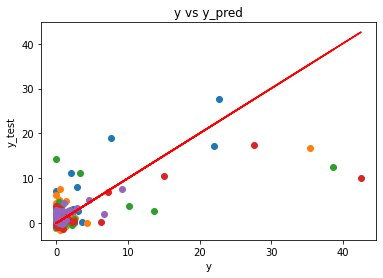

In [ ]:
import lightgbm as lgb

# 5分割交差検証を指定し、インスタンス化
from sklearn.model_selection import KFold
kf = KFold(n_splits=5, shuffle=True, random_state=0)

# スコアとモデルを格納するリスト
score_list = []
models = []

for fold_, (train_index, valid_index) in enumerate(kf.split(x_all, y_all)):    
    print(f'fold{fold_ + 1} start')
    train_x = x_all.iloc[train_index]
    valid_x = x_all.iloc[valid_index]
    train_y = y_all[train_index]
    valid_y = y_all[valid_index]

    # lab.Datasetを使って、trainとvalidを作っておく
    lgb_train= lgb.Dataset(train_x, train_y)
    lgb_valid = lgb.Dataset(valid_x, valid_y)
    
    lgb_results = {} 

    # パラメータを定義
    #lgbm_params = {'objective': 'regression'}

    # lgb.trainで学習
    gbm = lgb.train(params,                    # ハイパーパラメータをセット
                    lgb_train,              # 訓練データを訓練用にセット
                    valid_sets=[lgb_train, lgb_valid], # 訓練データとテストデータをセット
                    valid_names=['Train', 'Test'],    # データセットの名前をそれぞれ設定
                    num_boost_round=100,              # 計算回数
                    early_stopping_rounds=50,         # アーリーストッピング設定
                    evals_result=lgb_results,
                    verbose_eval=-1,
                        
                    )
    
    y_pred = gbm.predict(valid_x)

    correlation = np.corrcoef(valid_y,y_pred)
    r2 = correlation[0,1]*correlation[0,1]

    score_list.append(r2)
    models.append(gbm)  # 学習が終わったモデルをリストに入れておく
    
    # 散布図を描画(真値 vs 予測値)
    plt.plot(valid_y, valid_y, color = 'red', label = 'x=y') # 直線y = x (真値と予測値が同じ場合は直線状に点がプロットされる)
    plt.scatter(valid_y, y_pred) # 散布図のプロット
    plt.xlabel('y') # x軸ラベル
    plt.ylabel('y_test') # y軸ラベル
    plt.title('y vs y_pred') # グラフタイトル
    print(f'fold{fold_ + 1} end\n' )

print(score_list, '平均score', np.mean(score_list))

##特徴量重要度に基づく特徴量選択

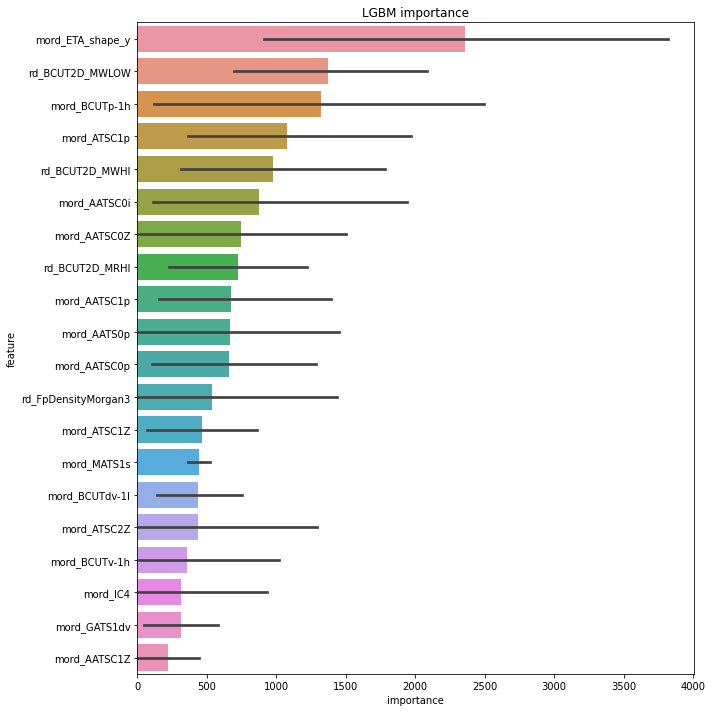

In [ ]:
# 特徴量重要度を保管する dataframe を用意
feature_importances = pd.DataFrame()

for fold, model in enumerate(models):

    tmp = pd.DataFrame()
    tmp['feature'] = model.feature_name()
    tmp['importance'] = model.feature_importance(importance_type='gain')
    tmp['fold'] = fold

    feature_importances = feature_importances.append(tmp)

# 各特徴量で集約して、重要度の平均を算出。上位20個だけ抜き出す
order = list(feature_importances.groupby("feature")["importance"].mean().sort_values(ascending=False).index)[:20]

# 可視化
plt.figure(figsize=(10, 10))
sns.barplot(x='importance', y='feature', data=feature_importances, order=order)
plt.title('LGBM importance')
plt.tight_layout()
plt.show()

In [ ]:
#特徴量を選択する
f=x_all[["mord_ETA_shape_y","rd_BCUT2D_MWLOW","mord_BCUTp-1h","mord_ATSC1p","rd_BCUT2D_MWHI","mord_AATSC0i","mord_AATSC0Z","rd_BCUT2D_MRHI","mord_AATSC1p","mord_AATS0p","mord_AATSC0p",'rd_FpDensityMorgan3','mord_ATSC1Z','mord_MATS1s', 'mord_BCUTdv-1l','mord_ATSC2Z','mord_BCUTv-1h', 'mord_IC4', 'mord_GATS1dv',]]

#f=x_all[["mord_ATSC2v","mord_ATSC2p","mord_ATSC3d","rd_Chi4n","mord_Xc-5dv","mord_SlogP_VSA4","mord_ATS3d","rd_BCUT2D_LOGPHI","mord_Xp-3dv","mord_AETA_eta","mord_ATSC2i",'rd_BCUT2D_MWLOW','mord_Xpc-5dv',]]
#f=x_all[["rd_BCUT2D_MWLOW","mord_IC4","mord_AATSC0i","mord_AATS0p","mord_ATSC1p","mord_BCUTp-1h","mord_AATSC0Z","mord_AATSC1p","mord_FilterItLogS","mord_AATSC0m","mord_BCUTi-1l",'mord_IC3','mord_MATS1p','rd_BCUT2D_MWHI',]]

fold1 start
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[46]	Train's rmse: 3.71241	Test's rmse: 2.96067
fold2 start
Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 3.11323	Test's rmse: 3.43168
fold3 start
Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 2.45027	Test's rmse: 5.54552
fold4 start
Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 2.76316	Test's rmse: 4.48517
fold5 start
Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 2.91214	Test's rmse: 1.60198
[0.7306397249858457, 0.743504789775259, 0.4554744780893549, 0.9211147725979575, 0.5769909780726883] 平均score 0.6855449487042211


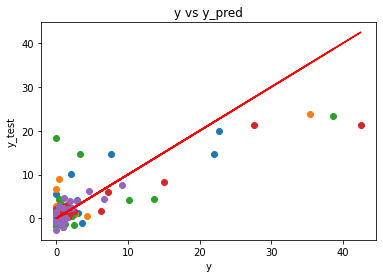

In [ ]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=5, shuffle=True, random_state=0)

# スコアとモデルを格納するリスト
score_list = []
models = []

for fold_, (train_index, valid_index) in enumerate(kf.split(f, y_all)):    
    print(f'fold{fold_ + 1} start')
    train_x = f.iloc[train_index]
    valid_x = f.iloc[valid_index]
    train_y = y_all[train_index]
    valid_y = y_all[valid_index]

    # lab.Datasetを使って、trainとvalidを作っておく
    lgb_train= lgb.Dataset(train_x, train_y)
    lgb_valid = lgb.Dataset(valid_x, valid_y)

    # パラメータを定義
    #lgbm_params = {'objective': 'regression'}

    params = {
          'task': 'train',              # タスクを訓練に設定
          'boosting_type': 'gbdt',      # GBDTを指定
          'objective': 'regression',    # 回帰を指定
          'metric': 'rmse',             # 回帰の損失（誤差）
          'learning_rate': 0.1,         # 学習率                # シード値
          }

    # lgb.trainで学習
    gbm = lgb.train(params,                    # ハイパーパラメータをセット
                    lgb_train,              # 訓練データを訓練用にセット
                    valid_sets=[lgb_train, lgb_valid], # 訓練データとテストデータをセット
                    valid_names=['Train', 'Test'],    # データセットの名前をそれぞれ設定
                    num_boost_round=100,              # 計算回数
                    early_stopping_rounds=50,         # アーリーストッピング設定
                    evals_result=lgb_results,
                    verbose_eval=-1,
                    )
    
    y_pred = gbm.predict(valid_x)

    correlation = np.corrcoef(valid_y,y_pred)
    r2 = correlation[0,1]*correlation[0,1]



    score_list.append(r2)
    models.append(gbm)  # 学習が終わったモデルをリストに入れておく

    # 散布図を描画(真値 vs 予測値)
    plt.plot(valid_y, valid_y, color = 'red', label = 'x=y') # 直線y = x (真値と予測値が同じ場合は直線状に点がプロットされる)
    plt.scatter(valid_y, y_pred) # 散布図のプロット
    plt.xlabel('y') # x軸ラベル
    plt.ylabel('y_test') # y軸ラベル
    plt.title('y vs y_pred') # グラフタイトル
    #print(f'fold{fold_ + 1} end\n' )
print(score_list, '平均score', np.mean(score_list))